# SIAMESE NETWORK

SIAMESE Network is a model with two identical sub networks. The output of these subnetworks are compared using Euclidean distance Logic

It is designed to take two inputs pass it through the subnetwork and then output their similarity or differences.

if you like my work: Do consider following me. Feel free to email me at sheharyarfaisal1@gmail.com

Problems Faced with conclusions;
* Note in training your accuracy falls thats a unique case in this example (dont worry about it)
* Work on graph visualisation Done
* See how embeddings work - Conclusion out of 128 values there were only 5 active values the rest were 0 does that mean that rather than having 128 neurons in the dense layer we can make do with 5
* If Conv2D can produce similar results ; Yes it does
* How does lambda function actually work; The Eucl_shape is used to output a batch size x 1 vector indicating 0 or 1 chance

Solution: Used Flatten Layer in the architecute + the input layer shape=(28,28,)
___

The solution proposed here relies on two basic model:
  * DNN ; A dense neural network
  * CNN ; A CNN based neural network

  Both show similar accuracy and similarity results


# IMPORTS

In [1]:
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Conv2D,Dense,Input,Dropout,Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw,ImageFont
import random
from tensorflow.keras.layers import MaxPooling2D
!apt-get -qq install -y graphviz
!pip install pydot
from tensorflow.keras.utils import plot_model

# Data Loading and Preprocessing

In [2]:
from keras.datasets import mnist

In [3]:
(x_train,y_train), (x_test,y_test)=mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


x_train consists of 60000 images of dimension

In [4]:
print(x_train.shape)

(60000, 28, 28)


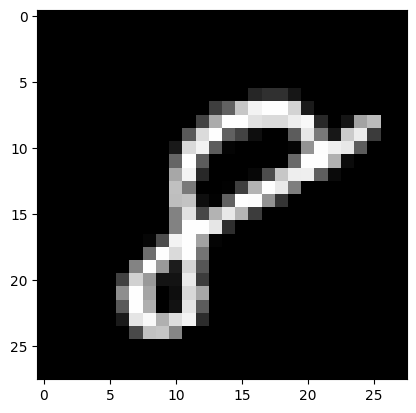

8


In [ ]:
# Specify the index of the image you want to view (e.g., 0 for the first image)
image_index = 59999

# Get the image data
image = x_train[image_index]

# Reshape the image data to its original dimensions (28x28 pixels)
# This is necessary because the data is stored in a flattened one-dimensional array
image = image.reshape(28, 28)

# Display the image using matplotlib
plt.imshow(image, cmap='gray')
plt.show()
print(y_train[image_index])

In [5]:
#Preprocess Images : Normalizes the Images and converts into a float data type
x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0


___
**NOTE:**  A siamese network accepts data/images in the form of pairs.

  * If both image are belong to same class : A label of 1 is used
  * If both belong to different classs     : A label of 0 is used


  Below are different types of function used to generate the dataset:
    You can use any the uncommented one is the one which generates equal number of true positive and true negative.

    P.S If you face any issue with the commented try to convert the output to a numpy array, it should work

In [ ]:
'''
def create_pairs (x, digit_indices):
  pairs = []
  labels = []
  n = min([len (digit_indices [d]) for d in range(10)]) - 1
  for d in range(10):
    for i in range(n):
      z1 , z2 = digit_indices [d][i], digit_indices [d][i + 1]
      pairs += [[x[21], x[22]]]
      inc = random.randrange (1, 10)
      dn  = (d + inc) % 10
      z1, z2= digit_indices [d][i], digit_indices [dn][i]
      pairs += [[x[z1], x[z2]]]
      labels=[1, 0]
  return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
  digit_indices = [np.where(labels == i)[0] for i in range(10)]
  pairs, y = create_pairs(images, digit_indices)
  y=y.astype('float32')
  return pairs, y
  '''

In [ ]:
#Creates pairs of images
'''
def random_indices(labels):

  # Define the lower and upper bound for random number generation
  lower_bound = 0
  upper_bound = len(labels)-1

  # Generate the first random number
  first_number = random.randint(lower_bound, upper_bound)
  return first_number



def create_dataset(images, labels):
  new_pairs=[]
  new_labels=[]
  for i in range(len(labels)):

    index1=random_indices(labels)
    if (labels[i]==labels[index1]):
      new_labels.append(1)
    else:
      new_labels.append(0)

    new_pairs.append([images[i],images[index1]])
    new_labels=new_labels
  return new_pairs,new_labels
'''

In [6]:
#Test 2 of equal true and false labels
import random
import numpy as np

def random_indices(labels, exclude_index=None):
    lower_bound = 0
    upper_bound = len(labels) - 1
    while True:
        index = random.randint(lower_bound, upper_bound)
        if index != exclude_index:
            return index

def create_dataset(images, labels):
    new_pairs = []
    new_labels = []
    num_pairs = len(labels) // 2  # Adjust to create an equal number of positive and negative pairs

    # Create positive pairs
    for _ in range(num_pairs):
        while True:
            index1 = random.randint(0, len(labels) - 1)
            index2 = random_indices(labels, exclude_index=index1)
            if labels[index1] == labels[index2]:
                new_pairs.append([images[index1], images[index2]])
                new_labels.append(1)
                break

    # Create negative pairs
    for _ in range(num_pairs):
        while True:
            index1 = random.randint(0, len(labels) - 1)
            index2 = random_indices(labels, exclude_index=index1)
            if labels[index1] != labels[index2]:
                new_pairs.append([images[index1], images[index2]])
                new_labels.append(0)
                break

    return new_pairs, new_labels

# Example usage
# new_pairs, new_labels = create_dataset(images, labels)


In [7]:
new_pairs,new_labels=create_dataset(x_train,y_train) #This approach had an issue of ~50000:1 and 6000 :0
test_pairs,test_labels=create_dataset(x_test,y_test)

In [ ]:
#new_pairs,new_labels=create_pairs_on_set(x_train,y_train)
#test_pairs,test_labels=create_pairs_on_set(x_test,y_test)

In [8]:
new_pairs=np.array(new_pairs)
test_pairs=np.array(test_pairs)
new_labels=np.array(new_labels).astype('float32')
test_labels=np.array(test_labels).astype('float32')

In [2]:
#Used to visualise both images side by side : With their labels
def image_viewer(image,new_labels,index):
  '''
  image pass image dataset with both input images
  new_labels pass the labels of the images
  index pass the index of the image you want to view
  '''
  image1=image[index][0].reshape(28,28)
  image2=image[index][1].reshape(28,28)
  # Display the image using matplotlib
  # Create a figure for plotting two images side-by-side
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize for better viewing

  # Display the first image
  ax1.imshow(image1, cmap='gray')
  ax1.set_title(f"Image 0 Label: {new_labels[index]}")  # Add title with label
  ax1.axis('off')  # Hide axes for cleaner presentation

  # Display the second image (index + 1, handling potential out-of-bounds)
  ax2.imshow(image2, cmap='gray')
  ax2.set_title(f"Image 1 : Label {new_labels[index]}")  # Add title with label
  ax2.axis('off')  # Hide axes

  # Adjust layout for better spacing
  plt.tight_layout()

  plt.show()



In [ ]:
image_viewer(new_pairs,new_labels,500)

____
MODEL DEFINITION;

A Dense Neural Network

In [17]:
input_left =Input(shape=(28,28,))
input_right=Input(shape=(28,28,))


def Conv_block():

  input=Input(shape=(28,28,1),name='base_input')
  x=Flatten(name='Flatten_inpu')(input)
  x=Dense(128,activation='relu',name='first_base_dense')(x)
  x=Dropout(0.1,name='first_output')(x)
  #x=Conv2D(16,(7,7),name='Conv_base_1')(input)
  x=Dense(128,activation='relu',name='second_base_dense')(x)
  x=Dropout(0.1,name='second_output')(x)
  x=Dense(128,activation='relu',name='third_base_dense')(x)


  return Model(inputs=input,outputs=x)


A Convolutional Neural Netowrk Approach

In [10]:

  def Conv_block():
    input=Input(shape=(28,28,1),name='base_input')
    x = Conv2D(64, (7,7), strides=1, padding='same', activation='relu')(input)
    x = MaxPooling2D(pool_size=2, strides=2)(x)

    x = Conv2D(128, (5,5), strides=1, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)

    x = Conv2D(256, (3,3), strides=1, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)

    x = Flatten()(x)

    # Fully connected layers
    x = Dense(1024, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(5)(x)

    return Model(inputs=input, outputs=x)


In [11]:
base_network=Conv_block()

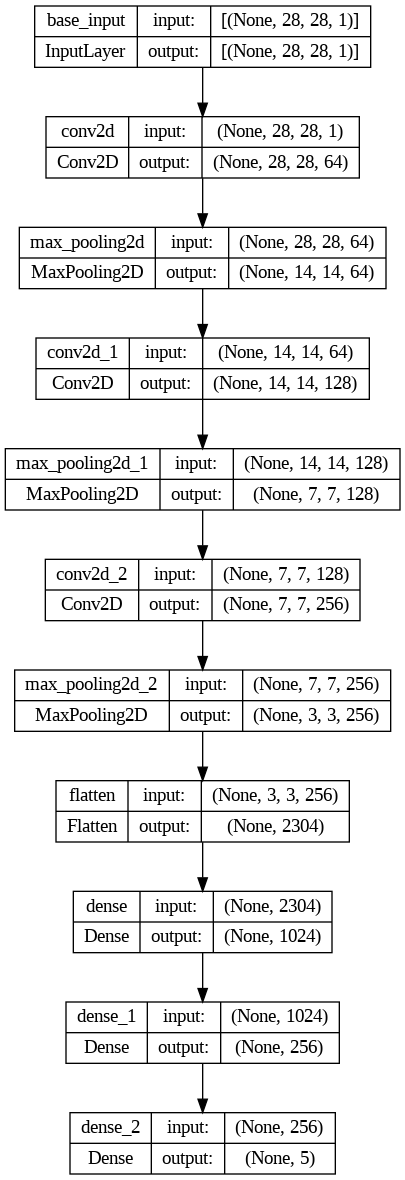

In [12]:
plot_model(base_network,show_shapes=True,show_layer_names=True,to_file='Siamese_base.png')

Defining the euclidean distance to be compared between the embeddings generated between the output of each sub network

In [13]:
def euclidean_distance(vects):
  x,y=vects
  sum_square=K.sum(K.square(x-y),axis=1,keepdims=True)
  return K.sqrt(K.maximum(sum_square,K.epsilon()))
def eucl_dist_output_shape(shapes):
  shape1,shape2=shapes
  return (shape1[0],1)

In [14]:
input_left=Input(shape=(28,28,),name='Left_Input')
input_right=Input(shape=(28,28,),name='Right_Input')
output_left =base_network(input_left)
output_right=base_network(input_right)

#The output shape of eucl_distance_shape is technically batch size x1 since our final answer should either be 0 or 1
output = Lambda(euclidean_distance, name='Output_Layer', output_shape=eucl_dist_output_shape)([output_left, output_right])

model=Model(inputs=[input_left,input_right],outputs=output)

<function eucl_dist_output_shape at 0x781fcd965240>


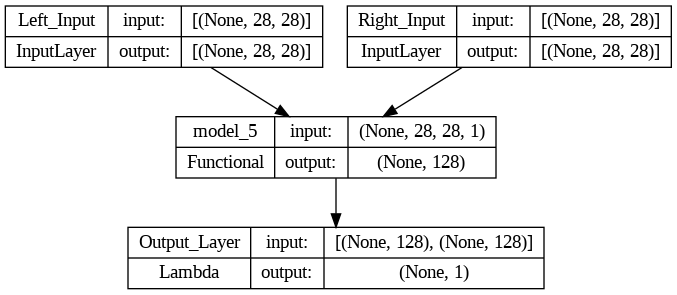

In [ ]:
plot_model(model,show_shapes=True,show_layer_names=True,to_file='Siamese_whole.png')

In [15]:
#Defining our own loass function
def contrastive_loss(margin=1):
    def loss(y_true, y_pred):
        #y_true = tf.cast(y_true, tf.float32)
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

In [16]:
rms=RMSprop()

In [17]:
model.compile(optimizer=rms,metrics=['accuracy'] ,
              loss=contrastive_loss())

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Left_Input (InputLayer)     [(None, 28, 28)]             0         []                            
                                                                                                  
 Right_Input (InputLayer)    [(None, 28, 28)]             0         []                            
                                                                                                  
 model (Functional)          (None, 5)                    3127301   ['Left_Input[0][0]',          
                                                                     'Right_Input[0][0]']         
                                                                                                  
 Output_Layer (Lambda)       (None, 1)                    0         ['model[0][0]',         

In [19]:
print("Shape of new_pairs:", new_pairs.shape)
print("Shape of new_labels:", new_labels.shape)
print("Shape of test_pairs:", test_pairs.shape)
print("Shape of test_labels:", test_labels.shape)


Shape of new_pairs: (60000, 2, 28, 28)
Shape of new_labels: (60000,)
Shape of test_pairs: (10000, 2, 28, 28)
Shape of test_labels: (10000,)


___
Training of MODEL

In [20]:
history=model.fit([new_pairs[:,0],new_pairs[:,1]],new_labels,epochs=32,batch_size=128,validation_data=([test_pairs[:,0],test_pairs[:,1]],test_labels))

Epoch 1/32
469/469 [==============================] - 21s 26ms/step - loss: 0.0624 - accuracy: 0.0652 - val_loss: 0.0201 - val_accuracy: 0.0137
Epoch 2/32
469/469 [==============================] - 10s 21ms/step - loss: 0.0148 - accuracy: 0.0110 - val_loss: 0.0103 - val_accuracy: 0.0088
Epoch 3/32
469/469 [==============================] - 10s 22ms/step - loss: 0.0069 - accuracy: 0.0053 - val_loss: 0.0094 - val_accuracy: 0.0086
Epoch 4/32
469/469 [==============================] - 10s 22ms/step - loss: 0.0036 - accuracy: 0.0025 - val_loss: 0.0076 - val_accuracy: 0.0080
Epoch 5/32
469/469 [==============================] - 10s 22ms/step - loss: 0.0021 - accuracy: 0.0012 - val_loss: 0.0053 - val_accuracy: 0.0054
Epoch 6/32
469/469 [==============================] - 10s 22ms/step - loss: 0.0014 - accuracy: 7.8333e-04 - val_loss: 0.0066 - val_accuracy: 0.0072
Epoch 7/32
469/469 [==============================] - 10s 22ms/step - loss: 7.2432e-04 - accuracy: 3.6667e-04 - val_loss: 0.0053 - v

In [21]:
def compute_accuracy(y_true, y_pred):
  pred=y_pred.ravel()>0.5
  return np.mean(pred == y_true)

In [22]:
y_pred_train=model.predict([new_pairs[:,0],new_pairs[:,1]])
train_accuracy=compute_accuracy(y_pred_train,new_labels)

y_pred_test = model.predict([test_pairs [:,0], test_pairs[:,1]])
test_accuracy=compute_accuracy (test_labels, y_pred_test)
print("Loss = {}, Train Accuracy () Test Accuracy = {}".format( train_accuracy, test_accuracy))

313/313 [==============================] - 1s 3ms/step
Loss = 0.0, Train Accuracy () Test Accuracy = 0.0069


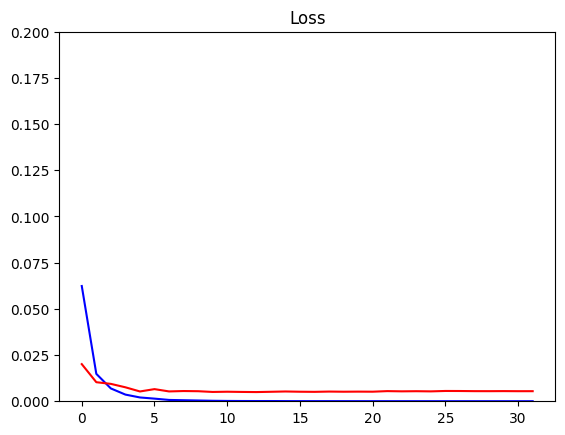

In [23]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_'+metric_name],color='red',label='val_'+metric_name)
plot_metrics(metric_name='loss', title='Loss', ylim=0.2)

In [24]:
y_pred_train=np.squeeze(y_pred_train)
indexes=np.random.choice(len(y_pred_train),size=10)


In [28]:
#This can be used to saved your Model
model.save('Siamese_Mnist_Conv.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
#Saving Model weights
model.save_weights('Siamese_Mnist_Conv_weights.h5')

___
Use the below two lines only if you wish to load your pretrained model

In [21]:
custom_loss = contrastive_loss(margin=1)

In [ ]:
#to load a model with a custom loss function you need to define custom_objects

from tensorflow.keras.models import load_model
model=load_model('Siamese_Mnist_Conv.h5',custom_objects={'loss': custom_loss})

____

In [25]:
import matplotlib.pyplot as plt
def display_images (left, right, predictions, labels, title, n):

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  plt.grid(None)
  left= np.reshape(left, [n, 28, 28])
  left = np.swapaxes (left, 0, 1)
  left= np.reshape(left, [28, 28*n])
  plt.imshow(left)
  plt.figure(figsize=(17,3))
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate (plt.gca().xaxis.get_ticklabels()):
    if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
  plt.grid(None)
  right = np.reshape(right, [n, 28, 28])
  right = np.swapaxes (right, 0, 1)
  right = np.reshape(right, [28, 28*n])
  plt.imshow(right)

plt.yticks([])
plt.xticks([])
This is used to set grid on x &y axis along with their labels

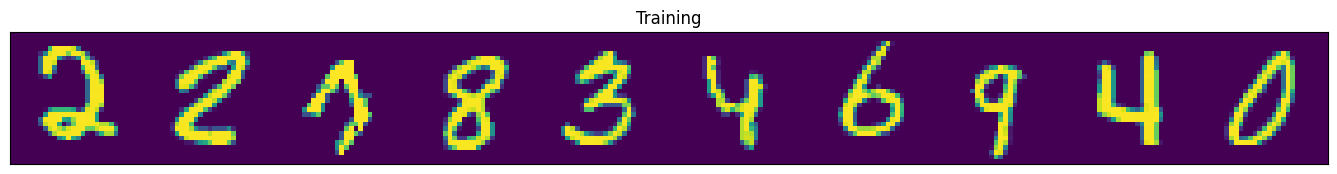

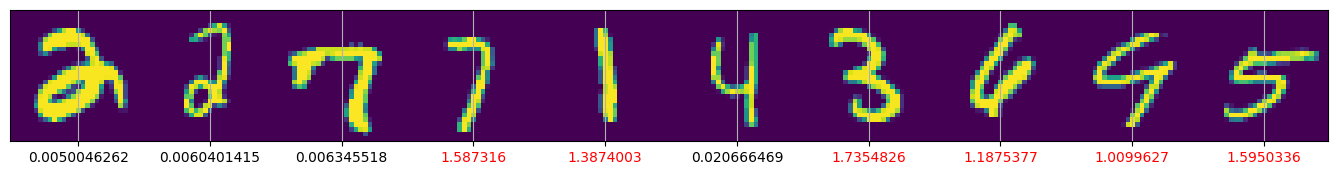

In [26]:
indexes = np.random.choice(len(new_labels), 10)
display_images(new_pairs[:,0][indexes],new_pairs[:,1][indexes],y_pred_train[indexes],new_labels[indexes],"Training",10)

___
# Exploring Embeddings of the Model

The below code is used to;
  * Create an embedding Model: This is used to view the output of the sub network
  * In the model the pretrained weights of the siamese model are fed

  * Using model.predict we can obtian the embedding result

In [30]:
base2=Conv_block()
input_left_trial = Input(shape=(28,28,), name='Left_Input_1')
output_left_trial = base2(input_left_trial)
embedding_model = Model(inputs=input_left_trial, outputs=output_left_trial)

In [32]:
# Create the Siamese network model again to ensure consistency in weights
input_left = Input(shape=(28, 28,), name='Left_Input')
input_right = Input(shape=(28, 28,), name='Right_Input')
output_left = base2(input_left)
output_right = base2(input_right)

# Define the Lambda layer for Euclidean distance
output = Lambda(euclidean_distance, name='Output_Layer', output_shape=eucl_dist_output_shape)([output_left, output_right])

# Define the Siamese network model
siamese_model = Model(inputs=[input_left, input_right], outputs=output)

# Load the trained weights into the Siamese network model
siamese_model.load_weights('Siamese_Mnist_Conv_weights.h5')

# Transfer weights from the base network in the Siamese model to the embedding model
embedding_model.set_weights(base2.get_weights())

# Verify by predicting with the embedding model
example_input = np.random.rand(1, 28, 28)  # Replace with your actual input data
embeddings = embedding_model.predict(example_input)

print('Embeddings:', embeddings)


1/1 [==============================] - 0s 232ms/step
Embeddings: [[ 0.19966169 -0.32096758  0.01546424 -0.48526937 -0.39223236]]


Loadind random images and checking their embeddings

In [33]:
def load_random_image(image_array):
  image=image_array.astype('float32')/255.0
  image= image.reshape(1, 28, 28)
  return image

In [34]:
image1=load_random_image(new_pairs[:,0][100])
image2=load_random_image(new_pairs[:,1][50])


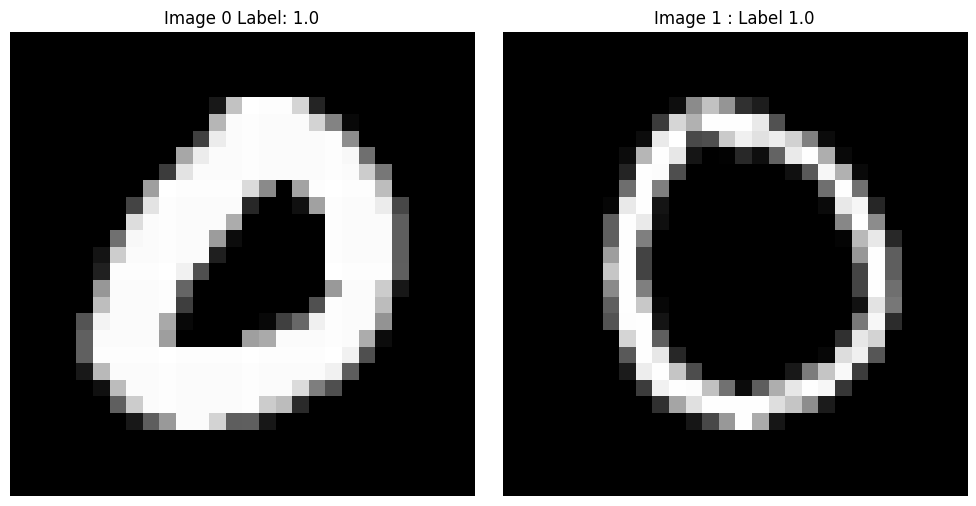

In [29]:
image_viewer(new_pairs,new_labels,0)

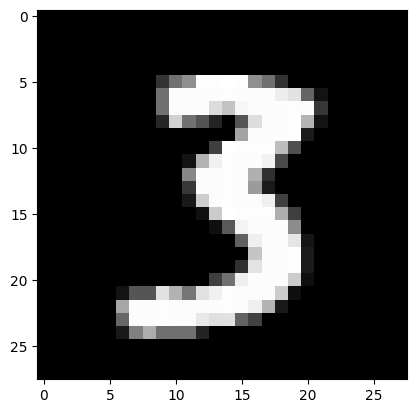

In [ ]:

# Display the image using matplotlib
plt.imshow(image1.reshape(28, 28), cmap='gray')
plt.show()

In [35]:
embedding_model.predict(image1) #Generate a 1 by 128 vector

1/1 [==============================] - 0s 18ms/step


array([[ 0.20324306, -0.36981046,  0.08618359, -0.16351575, -0.42173326]],
      dtype=float32)

In [36]:
embedding_model.predict(image2)

1/1 [==============================] - 0s 17ms/step


array([[ 0.2039512 , -0.36963284,  0.08690212, -0.16290441, -0.4199589 ]],
      dtype=float32)

Note : Do try this out its used to create a image showcasing how your embedding for each class is unique.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Define the visualize function
def visualize(embed, labels, method='tsne'):
    """
    Visualize the 2D embeddings.

    Parameters:
    embed : numpy array
        The embeddings to visualize, shape (n_samples, n_features).
    labels : numpy array
        The labels for the embeddings, shape (n_samples,).
    method : str
        The method for dimensionality reduction ('tsne' or 'pca').
    """
    if method == 'tsne':
        reducer = TSNE(n_components=2)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method should be 'tsne' or 'pca'.")

    reduced_embed = reducer.fit_transform(embed)

    labelset = set(labels.tolist())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    for label in labelset:
        indices = np.where(labels == label)
        ax.scatter(reduced_embed[indices, 0], reduced_embed[indices, 1], label=label, s=20)

    ax.legend()
    fig.savefig('embed_pca.jpeg', format='jpeg', dpi=600, bbox_inches='tight')
    plt.close()

# Generate some example data for demonstration (replace this with your own embeddings and labels)
# For instance, if your embeddings are in a file, load them:
# embeddings = np.loadtxt('embeddings.txt')

# Load your MNIST dataset or any dataset
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

# Suppose you have 1000 embeddings for visualization
num_samples = 1000
mnist_test_images = x_train[:num_samples]
mnist_test_labels = y_train[:num_samples]

# Assuming you have a trained model called `embedding_model`
# and `embedding_model.predict` gives you the embeddings

# Get the embeddings for the test images
embeddings = embedding_model.predict(mnist_test_images.reshape(-1, 28, 28, 1))

# Visualize the embeddings
visualize(embeddings, mnist_test_labels, method='tsne')


32/32 [==============================] - 1s 12ms/step


<--- Check image in your folder 